In [840]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import zscore


In [841]:
df = pd.read_parquet('../data/processed/imputed_df.parquet')
df = df.dropna(subset=['target'])
df = df.reset_index(drop=True)
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,target,OCCUPATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,18.0,20.0,Secondary / secondary special,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,Laborers,M,Cash loans
1,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,6.0,10.0,Higher education,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Core staff,F,Cash loans
2,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,16.0,17.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Laborers,M,Revolving loans
3,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,20.0,16.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Laborers,F,Cash loans
4,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,16.0,17.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Core staff,M,Cash loans


# Feature Engineering

## NUMERIC Variables

### Correcting the Skewness
Correcting the Skewness of the variables distribution consist of trying to get it closer to a normal distribution. Having data distributed normally improves the performance of our models. Tree based models are not sensitive to the scale of data so probably, our RF classificator will not get benefit from this. However, algorithms like Logistic Regression, Naive Bayes improve a lot when working with normally distributed data. SVM with a linear kernel also improve when they are fitted with this data since they assume the decision boundary between classes is linear. In addition, KNN algorithm, which needs to compute distances between data points also works better with normally distributed data because this distances tend to be smaller and more consistent.

As we have seen in the EDA, AMT_CREDIT is right-skewed so we will apply a log transformation to centre it.

First, lets check the distribution.

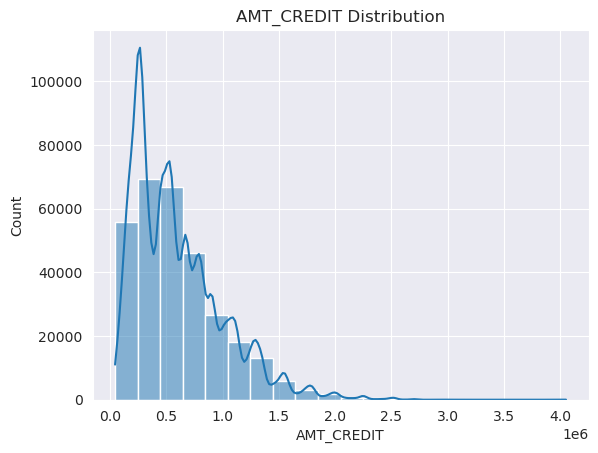

In [842]:
sns.histplot(df['AMT_CREDIT'], kde=True, bins=20)
plt.title("AMT_CREDIT Distribution")
plt.show()

Now let's see the transformation

In [843]:
amt_credit_sk = skew(df['AMT_CREDIT'])
print(f"Before applying the box-cox transformation: {amt_credit_sk}")

Before applying the box-cox transformation: 1.234765367664831


We are using the Box-Cox transformation instead of the log transformation because it is better to fix skewness since it allows adjustments to find the optimal transformation.

In [844]:
df['AMT_CREDIT_BOX-COX'],lamda2 = boxcox(df['AMT_CREDIT'] + 1)

In [845]:
amt_credit_sk = skew(df['AMT_CREDIT_BOX-COX'])
print(f"After applying the box-cox transformation: {amt_credit_sk}")

After applying the box-cox transformation: -0.024068341959405794


Now amt_credit is almost normally distributed, since the skewness is very close to 0.

In [846]:
df['AMT_CREDIT'] = df['AMT_CREDIT_BOX-COX']
df.drop(['AMT_CREDIT_BOX-COX'], axis=1, inplace=True)

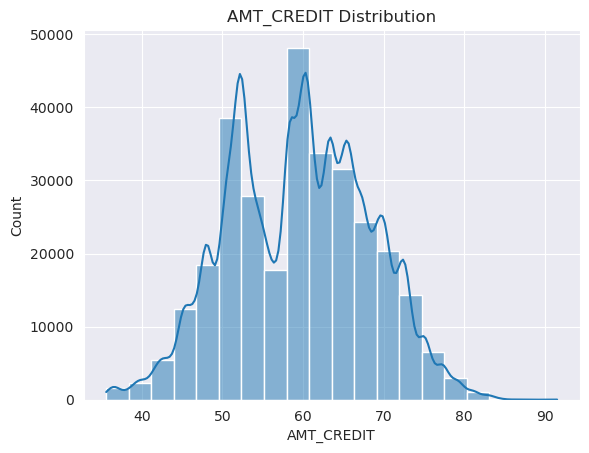

In [847]:
sns.histplot(df['AMT_CREDIT'], kde=True, bins=20)
plt.title("AMT_CREDIT Distribution")
plt.show()

We will do the same with AMT_GOODS_PRICE and AMT_ANNUITY since it is also right skewed.

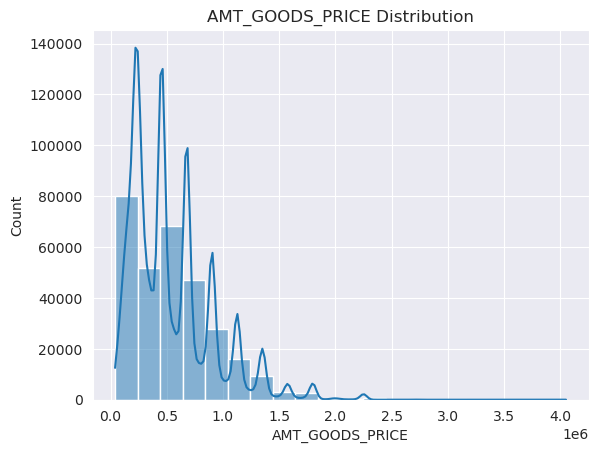

In [848]:
sns.histplot(df['AMT_GOODS_PRICE'], kde=True, bins=20)
plt.title("AMT_GOODS_PRICE Distribution")
plt.show()

In [849]:
df['AMT_GOODS_PRICE'],lamda3 = boxcox(df['AMT_GOODS_PRICE'] + 1)

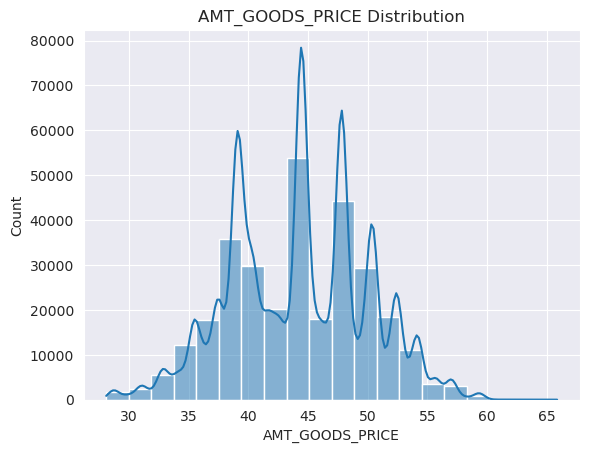

In [850]:
sns.histplot(df['AMT_GOODS_PRICE'], kde=True, bins=20)
plt.title("AMT_GOODS_PRICE Distribution")
plt.show()

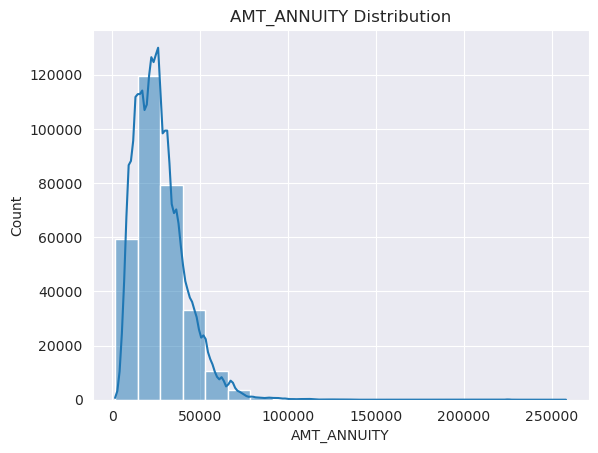

In [851]:
sns.histplot(df['AMT_ANNUITY'], kde=True, bins=20)
plt.title("AMT_ANNUITY Distribution")
plt.show()

In [852]:
df['AMT_ANNUITY'],lamda4 = boxcox(df['AMT_ANNUITY'] + 1)

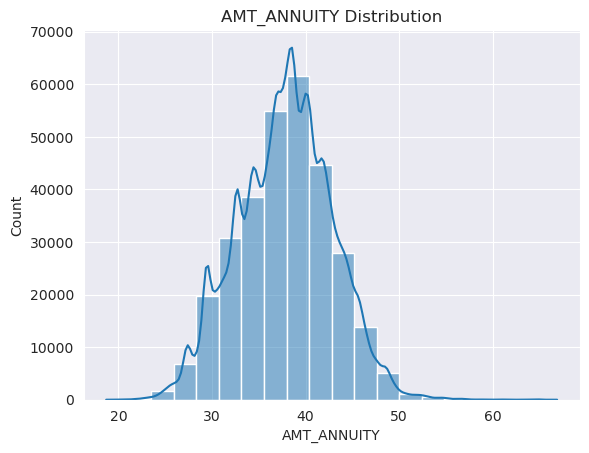

In [853]:
sns.histplot(df['AMT_ANNUITY'], kde=True, bins=20)
plt.title("AMT_ANNUITY Distribution")
plt.show()

In [854]:
df['AMT_INCOME_TOTAL'], lamda5 = boxcox(df['AMT_INCOME_TOTAL'] + 1)

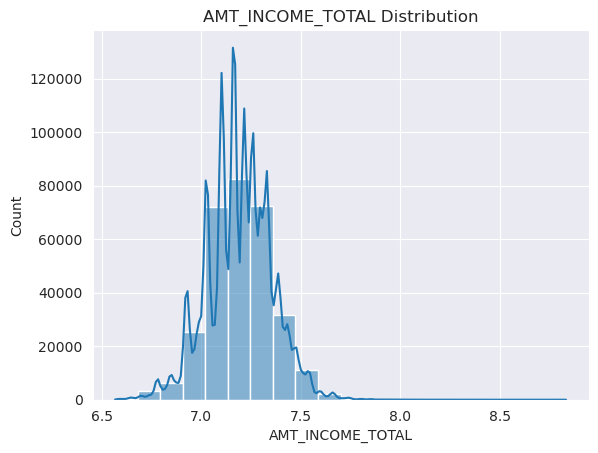

In [855]:
sns.histplot(df['AMT_INCOME_TOTAL'], kde=True, bins=20)
plt.title("AMT_INCOME_TOTAL Distribution")
plt.show()

In [856]:
amnt_inc_tot = skew(df['AMT_INCOME_TOTAL'])
print(f"After applying the box-cox transformation: {amnt_inc_tot}")

After applying the box-cox transformation: -0.008005938709423831


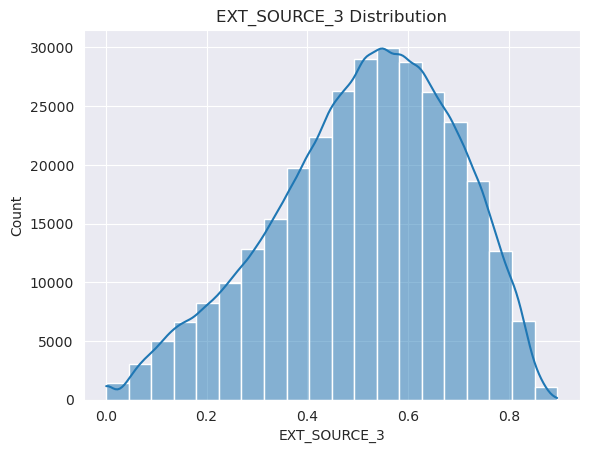

In [857]:
sns.histplot(df['EXT_SOURCE_3'], kde=True, bins=20)
plt.title("EXT_SOURCE_3 Distribution")
plt.show()

EXT_SOURCE_ are already normalized

### Outlier Removal

Some models such as Random Forests are not sensitive to outliers. Decision trees tend to find a split that minimizes a certain criterion and this consists in dividing the data into subsets. Since this splitting is based on a range of values and not on a particular one, outliers tend to have less impact in this process.

On the other hand, distance based algorithms, such as KNN, SVM, ... are more affected by outliers because they have a big impact on distance metrics. Logistic and linear regression are also affected because they are algorithms that try to reduce the sum of squared residuals and outliers can affect these calculations.



Firstly, we will check AMT_TOTAL_INCOME before removing outliers.

Text(0, 0.5, 'AMT_INCOME_TOTAL')

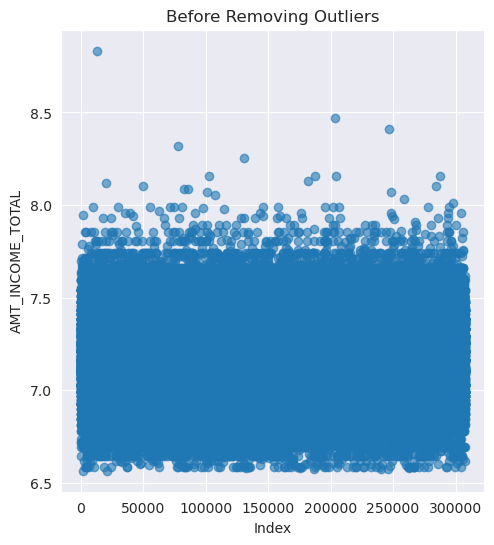

In [858]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(range(len(df)), df['AMT_INCOME_TOTAL'], alpha=0.6)
plt.title("Before Removing Outliers")
plt.xlabel("Index")
plt.ylabel("AMT_INCOME_TOTAL")

Now we will remove the outliers with the z-score threshold

In [859]:
threshold = 3
zscores = zscore(df['AMT_INCOME_TOTAL'])
non_outliers = np.abs(zscores < threshold)
print(df.shape)
data_cleaned = df[non_outliers]
print(data_cleaned.shape)

(307503, 74)
(306770, 74)


We have removed 733 samples from the dataset. We will check the removal using the IQR method.

In [860]:
Q1 = df['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = df['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
data_cleaned = df[(df['AMT_INCOME_TOTAL'] > lower) & (df['AMT_INCOME_TOTAL'] < upper)]
print(data_cleaned.shape)


(301081, 74)


Using the IQR method, the removal is of 6422 rows. However, when it comes to outlier detection, when data is normalized, zscore method works better. Since I have corrected the skewness before, we will accept the zscore method detections.

Now we will do the same with the rest of the numeric variables

In [861]:
numeric_vars = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'EXT_SOURCE_3', 'EXT_SOURCE_2']

We define a function for the outlier removal

In [862]:
def remove_outliers_zscore(df, columns, threshold=2.5):
    df_new = df.copy()
    for column in columns:
        if column in df_new.columns:
            z_scores = zscore(df_new[column])
            non_outliers = np.abs(z_scores) < threshold
            df_new = df_new[non_outliers]

    return df_new

In [863]:
no_outlier_data = remove_outliers_zscore(df, numeric_vars)
print(no_outlier_data.shape)

(296393, 74)


We have deleted 11110 outliers with the numeric variables.

## Categorical features

We will follow the following approach. We will remove categories that appear less than 5% of the times. We will define a function that does that for each of the columns.

In [864]:
def clean_categorical_data(df, columns, threshold=0.05):
    for column in columns:
        category_counts = df[column].value_counts()
        category_percentage = category_counts / len(df) * 100
        valid_categories = category_percentage[category_percentage >= threshold].index
        df = df[df[column].isin(valid_categories)]

    return df

In [865]:
# Extract de columns we do not want to clean.
numeric_vars = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'ORGANIZATION_TYPE', 'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE']
categorical_features = df.drop(columns=numeric_vars).columns.tolist()
categorical_features

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMEN

In [866]:
df = clean_categorical_data(df, categorical_features)
print(df.shape)

(294394, 74)


## Creating some new variables

Creating new variables can help us discover relationships that are not obvious in the original features.
This way, we can increase our predictive power.

In [867]:
# Income and credit ratios and difference
df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_GOODS_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_GOODS_PRICE']
df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['CREDIT_GOODS_DIFF'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']

# Time features
df['AGE_AT_APPLICATION'] = df['DAYS_BIRTH'] / -365

# Social features
df['SOCIAL_CIRCLE_ACTIVITY'] = df['OBS_30_CNT_SOCIAL_CIRCLE'] / df['DEF_30_CNT_SOCIAL_CIRCLE']

# Family features
df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

# Fixing the df frame
df.replace([np.inf, -np.inf], 0, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)

We will check the distribution for the new variables.

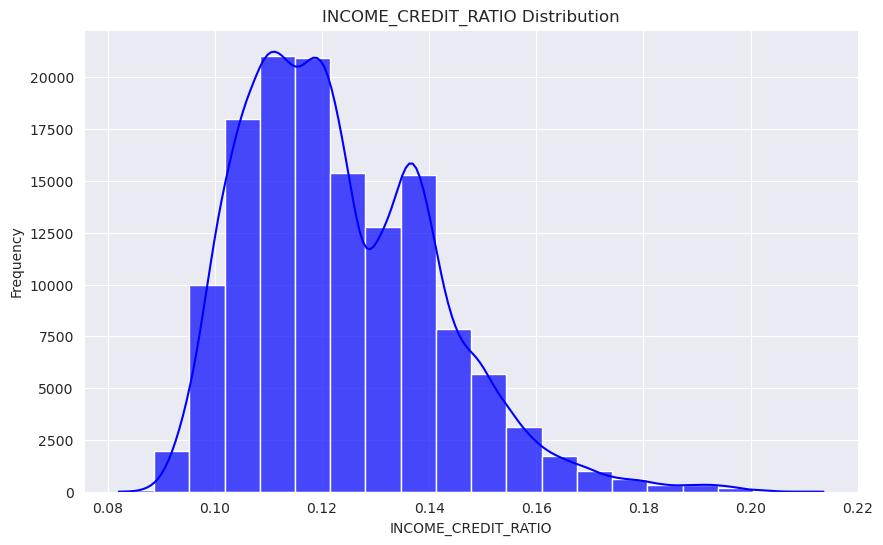

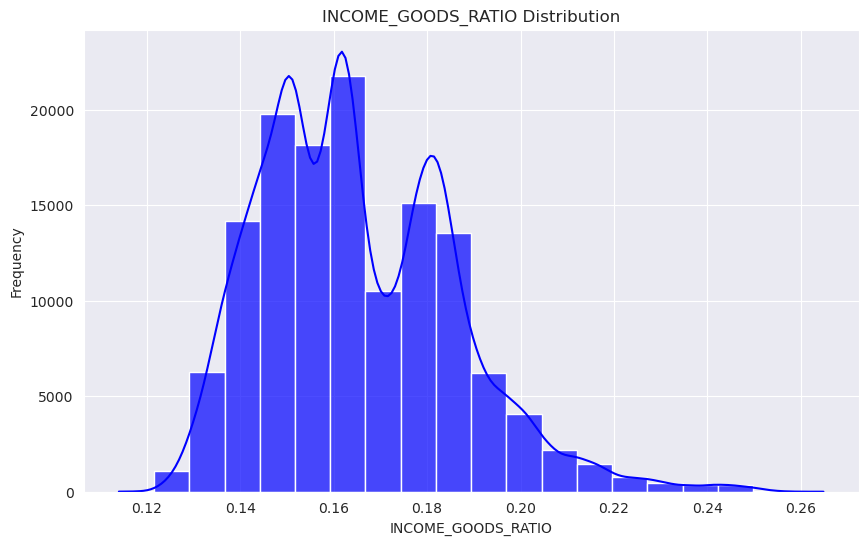

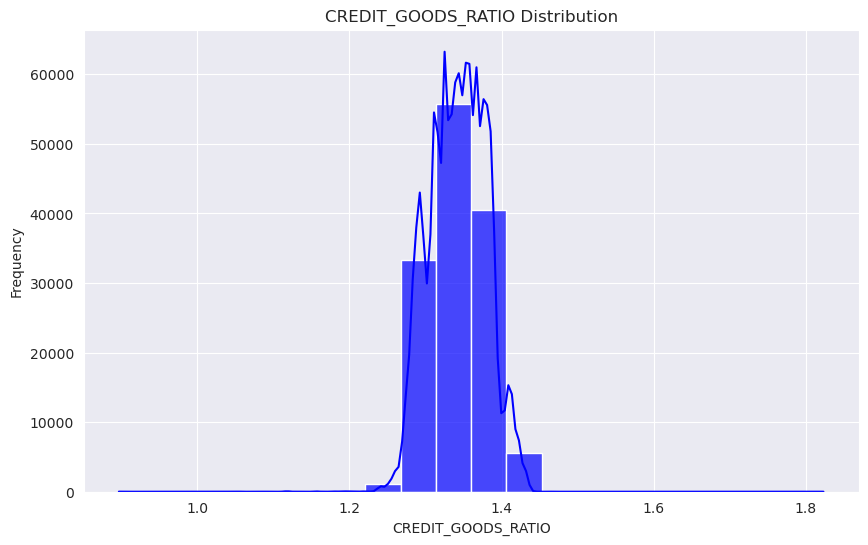

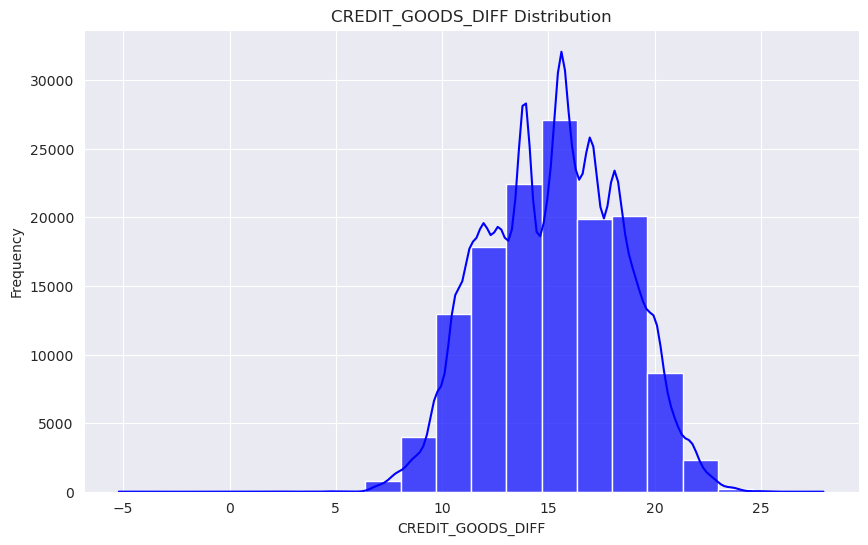

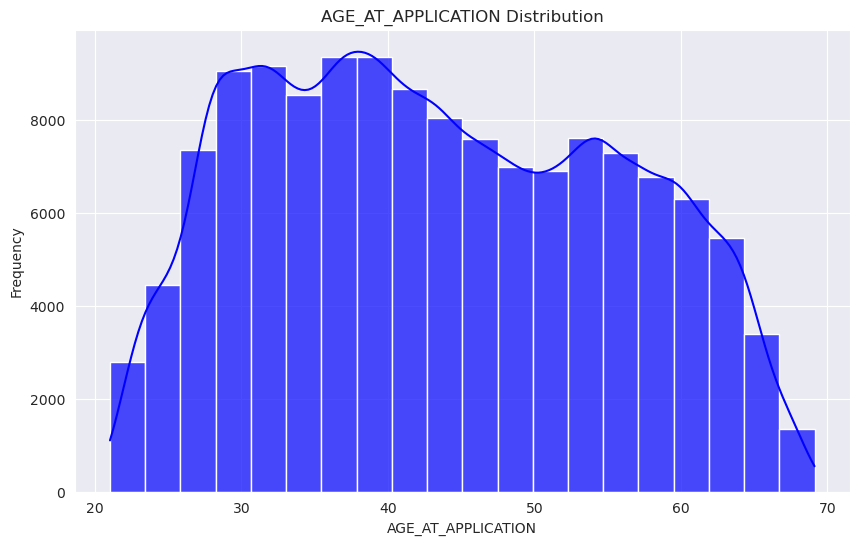

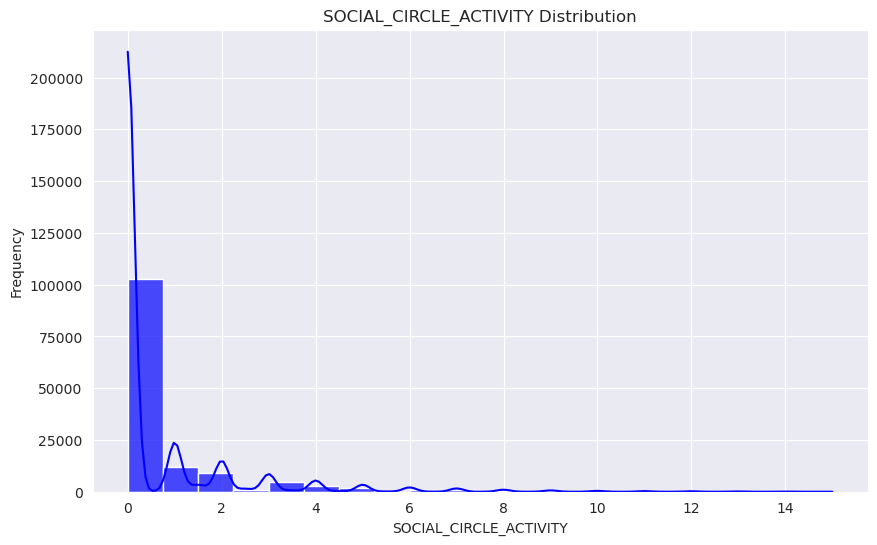

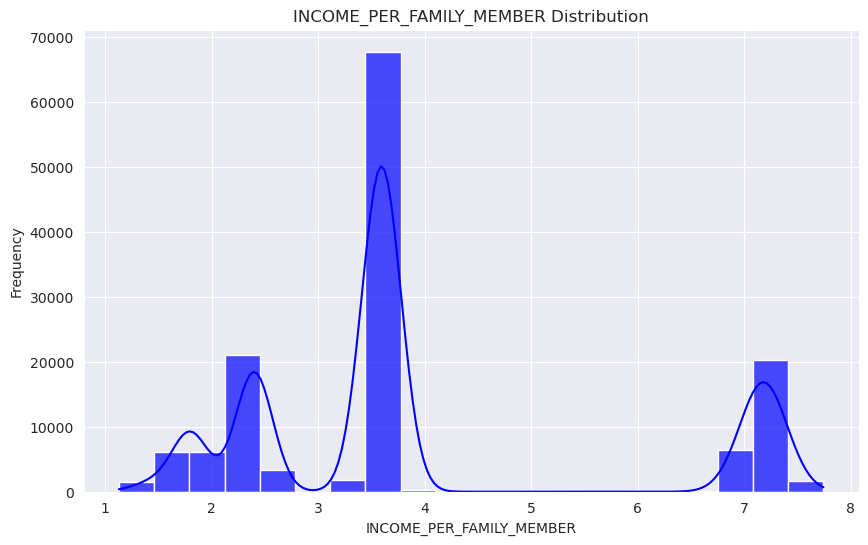

In [868]:
new_vars = ['INCOME_CREDIT_RATIO', 'INCOME_GOODS_RATIO','CREDIT_GOODS_RATIO', 'CREDIT_GOODS_DIFF', 'AGE_AT_APPLICATION',
            'SOCIAL_CIRCLE_ACTIVITY', 'INCOME_PER_FAMILY_MEMBER']
for var in new_vars:
    if var in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[var], kde=True, bins=20, color='blue', alpha=0.7)
        plt.title(f'{var} Distribution')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.show()

In [869]:
for var in new_vars:
    sk_var = skew(df[var])
    print(f"The skewness of {var} is: {sk_var}\n")

The skewness of INCOME_CREDIT_RATIO is: 0.7851610571423646

The skewness of INCOME_GOODS_RATIO is: 0.7094479138892809

The skewness of CREDIT_GOODS_RATIO is: -0.10516947460634811

The skewness of CREDIT_GOODS_DIFF is: -0.03868993498310914

The skewness of AGE_AT_APPLICATION is: 0.1541582815644428

The skewness of SOCIAL_CIRCLE_ACTIVITY is: 3.480191816380248

The skewness of INCOME_PER_FAMILY_MEMBER is: 0.9493799520049376



As we can see some variables are right-skewed so we are going to transform them using again the Box-Cox transformation.

In [870]:
df['SOCIAL_CIRCLE_ACTIVITY'], lamda6 = boxcox(df['SOCIAL_CIRCLE_ACTIVITY'] + 1)
skew(df['SOCIAL_CIRCLE_ACTIVITY'])

1.1959512671493662

1.19 is still too much right skewness but we have to leave it like that.

In [871]:
df['INCOME_PER_FAMILY_MEMBER'], lamda7 = boxcox(df['INCOME_PER_FAMILY_MEMBER'] + 1)
print(f"The new skewness for INCOME_PER_FAMILY_MEMBER is:{skew(df['INCOME_PER_FAMILY_MEMBER'])}")

The new skewness for INCOME_PER_FAMILY_MEMBER is:0.03457253442089558


In [872]:
df['INCOME_CREDIT_RATIO'], lamda7 = boxcox(df['INCOME_CREDIT_RATIO'] + 1)
print(f"The new skewness for INCOME_PER_FAMILY_MEMBER is:{skew(df['INCOME_CREDIT_RATIO'])}")

The new skewness for INCOME_PER_FAMILY_MEMBER is:0.05836023894052916


In [873]:
df['INCOME_GOODS_RATIO'], lamda8 = boxcox(df['INCOME_GOODS_RATIO'] + 1)
print(f"The new skewness for INCOME_GOODS_RATIO is:{skew(df['INCOME_GOODS_RATIO'])}")

The new skewness for INCOME_GOODS_RATIO is:0.04388474699244077


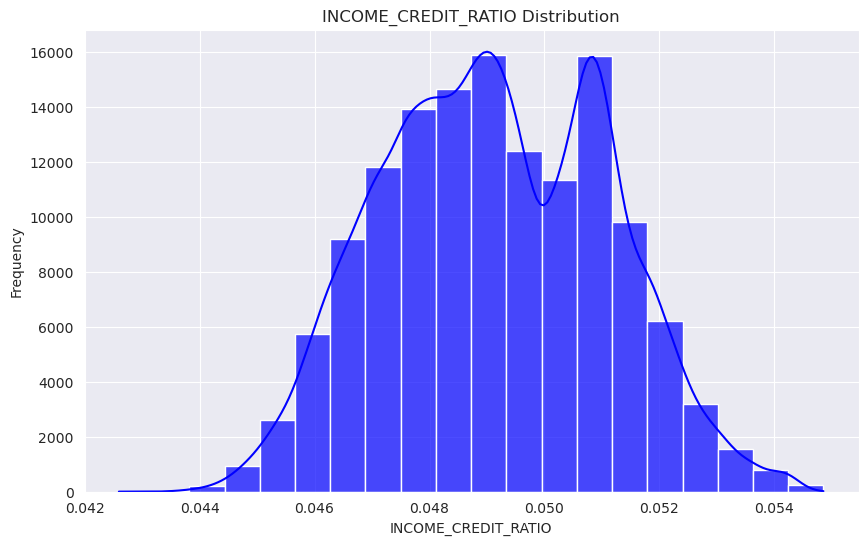

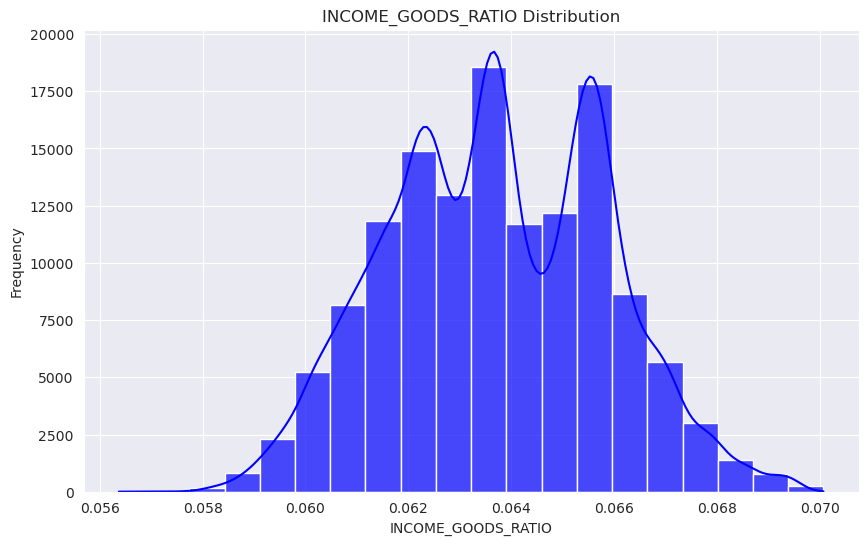

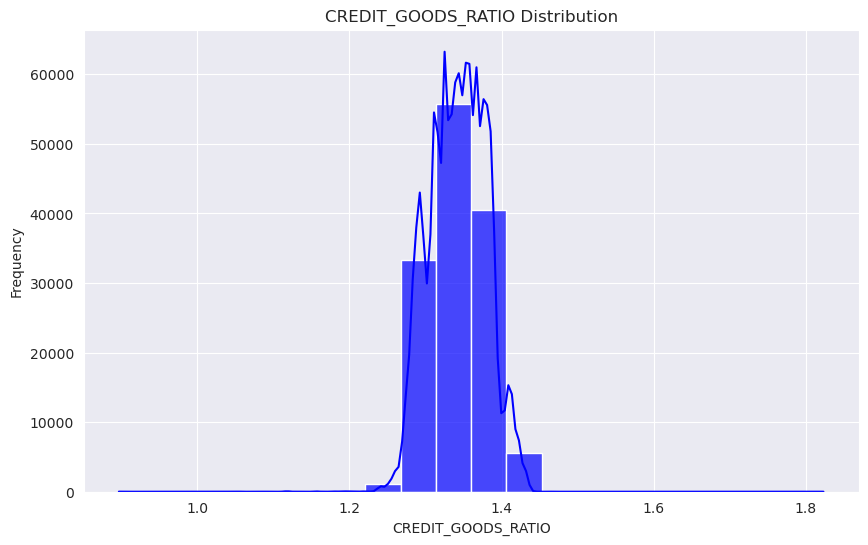

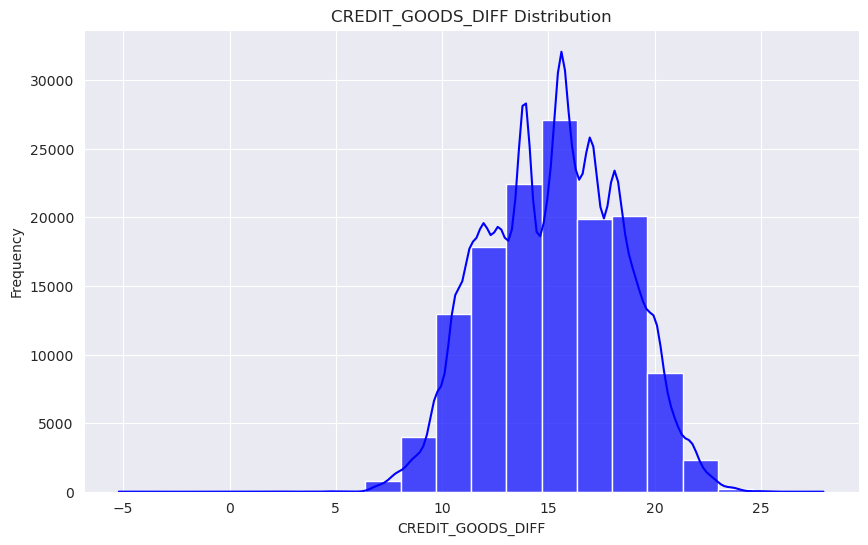

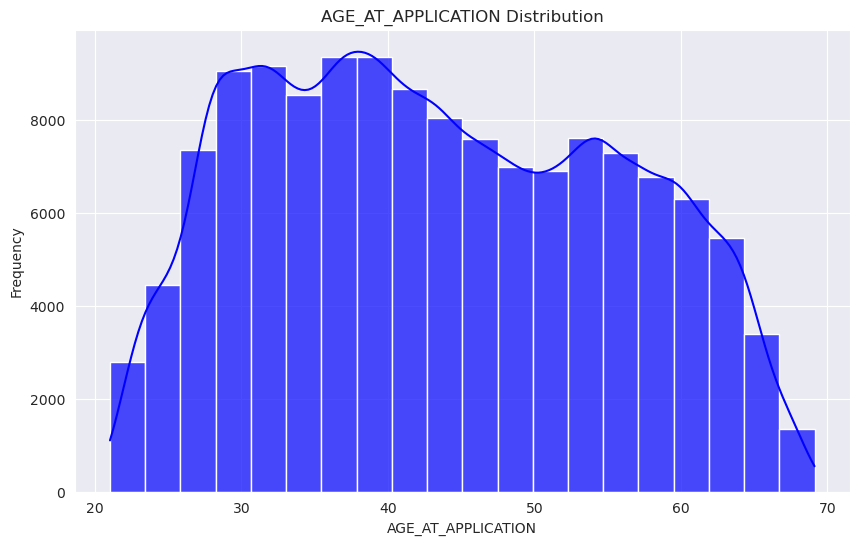

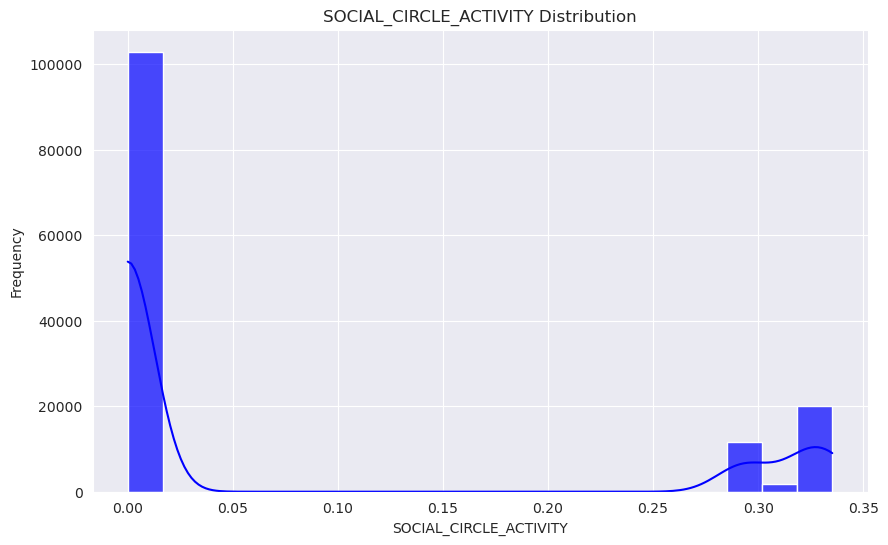

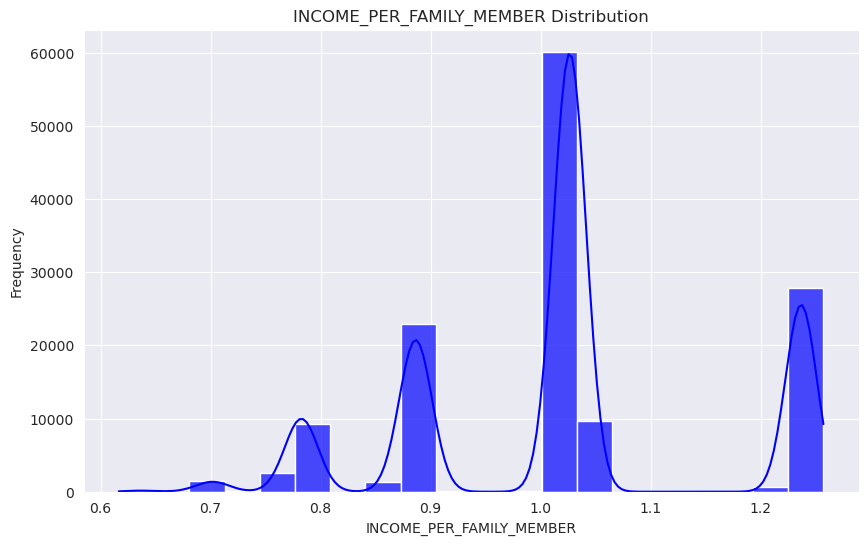

In [874]:
for var in new_vars:
    if var in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[var], kde=True, bins=20, color='blue', alpha=0.7)
        plt.title(f'{var} Distribution')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.show()

In [875]:
# Saving df
df.to_parquet('../df/processed/featured_df.parquet')